# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [88]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf
from pyspark.sql.types import IntegerType

from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import RandomForestClassifier, DecisionTreeClassifier, GBTClassifier


import re
import datetime
import pandas as pd

In [2]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Creating Features") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
sparkify_data = 'mini_sparkify_event_data.json'

df = spark.read.json(sparkify_data)
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [6]:
df.count()

286500

In [7]:
df1 = df.filter(~df.sessionId.isNull()).filter(df.userId != '')

In [8]:
df1.head(2)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9')]

In [9]:
df1.groupby('auth').count().show()

+---------+------+
|     auth| count|
+---------+------+
|Cancelled|    52|
|Logged In|278102|
+---------+------+



In [10]:
df1.groupby('gender').count().show()

+------+------+
|gender| count|
+------+------+
|     F|154578|
|     M|123576|
+------+------+



In [11]:
df1.select('userId').distinct().count()

225

In [12]:
df1.filter(df.page=='Cancellation Confirmation').select('userId').dropDuplicates().count()

52

In [13]:
convert_unix = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

Churn is defined below as any userId that has seen the cancellation confirmation page.

In [14]:
churn_users = df1.filter(df.page=='Cancellation Confirmation').select('userId').dropDuplicates()

In [15]:
churn_users_list = [(row['userId']) for row in churn_users.collect()]

In [16]:
churn_flag = udf(lambda x: 1 if x else 0, IntegerType())

In [17]:
df_1 = df1.withColumn("churn", df1.userId.isin(churn_users_list))

In [18]:
df_1 = df_1.withColumn("churn", churn_flag(df_1.churn))

Find the pages viewed broken out by whether the user churned or not

In [19]:
df_page_churn = df_1.groupby('page','churn').count().toPandas()

In [20]:
df_page_churn = df_page_churn[df_page_churn['page']!='NextSong']

In [21]:
df_page_churn = pd.pivot_table(df_page_churn,columns='churn',index='page',values='count',fill_value=0).reset_index()

In [22]:
no_churn = df_page_churn[0].sum()

In [23]:
churn = df_page_churn[1].sum()

In [24]:
df_page_churn[1] = df_page_churn[1]/churn
df_page_churn[0] = df_page_churn[0]/no_churn

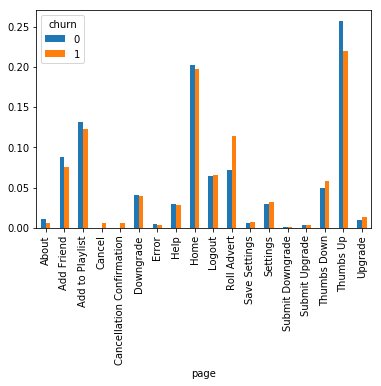

In [100]:
df_page_churn.plot.bar('page')

Convert unix timestamp to normal timestamp

In [27]:
convert_unix = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))

In [28]:
df_1 = df_1.withColumn("p_time",convert_unix(df_1.ts))

Find difference in the mean number of unique songs listed to by a user who churned vs those that didn't

In [30]:
df_song = df_1.select('userId','song','churn')

In [31]:
df_song = df_song.dropDuplicates().groupby('userId','song','churn').count()

In [32]:
df_song = df_song.groupby('userId','churn').sum('count').toPandas()

In [33]:
churn_count = df_song[df_song['churn']==1]['userId'].count()
df_churn = df_song[df_song['churn']==1]
no_churn_count = df_song[df_song['churn']==0]['userId'].count()
df_no_churn = df_song[df_song['churn']==0]

In [34]:
df_churn['sum(count)'].mean()

639.36538461538464

In [35]:
df_no_churn['sum(count)'].mean()

976.76300578034682

Users who churned listened to less songs on average, than those who didn't churn

Find difference in the mean number of unique artists listed to by a user who churned vs those that didn't

In [36]:
df_artist = df_1.select('userId','artist','churn').dropDuplicates().groupby('userId','artist','churn').count()

In [37]:
df_artist_churn = df_artist.filter(df_artist.churn==1).groupby('userId','churn').sum('count').toPandas()
df_artist_nochurn = df_artist.filter(df_artist.churn==0).groupby('userId','churn').sum('count').toPandas()

In [38]:
df_artist_churn['sum(count)'].mean()

519.69230769230774

In [39]:
df_artist_nochurn['sum(count)'].mean()

750.7803468208092

Users who churned listened to less artists on average, than those who didn't churn

Given the above results, I will need to provide as many features that highlights the number of interactions with Sparkify, as that seems to be a significant determinant as to whether the users churn or not. Also, there were some significant differences between the pages viewed by non-churners vs churners. That will also need to be included in the features.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

Number of Days since Registration

In [40]:
df_time_diff = df_1.groupby('userId').max('ts','registration')

In [41]:
df_time_diff = df_time_diff.withColumn('time_diff', ((df_time_diff['max(ts)']-df_time_diff['max(registration)'])/(1000*60*60*30))).sort('userId')\
.select('userId','time_diff')

Number of unique Artists played

In [42]:
df_artist = df_1.select('userId','artist').filter(~df_1.artist.isNull()).dropDuplicates().groupby('userId').count()

In [43]:
df_artist = df_artist.withColumnRenamed('count','num_unique_artist')

Number of unique Songs Played

In [44]:
df_song = df_1.select('userId','song').filter(~df_1.song.isNull()).dropDuplicates().groupby('userId').count()

In [45]:
df_song = df_song.withColumnRenamed('count','num_unique_songs')

Normalize Gender

In [46]:
dummy_gender = udf(lambda x: 1 if x =='M' else 0, IntegerType())
df_1 = df_1.withColumn('gender',dummy_gender(df_1.gender))

Number of Sessions

In [47]:
df_session = df_1.select('userId','sessionId').dropDuplicates().groupby('userId').count()

In [48]:
df_session = df_session.withColumnRenamed('count','num_sessions')

Songs per session

In [49]:
df_song_session = df_1.select('userId','sessionId','song').filter(~df_1.song.isNull()).dropDuplicates().groupby('userId').count()

In [50]:
df_song_session = df_song_session.withColumnRenamed('count','songs_per_session')

Min, Max and Average Time Per Session

In [51]:
min_session = df_1.select('userId','sessionId','ts').groupby('userId','sessionId').min('ts')
max_session = df_1.select('userId','sessionId','ts').groupby('userId','sessionId').max('ts')

In [52]:
joined_session = min_session.join(max_session,['userId','sessionId'])

In [53]:
joined_session.show()

+------+---------+-------------+-------------+
|userId|sessionId|      min(ts)|      max(ts)|
+------+---------+-------------+-------------+
|   101|      635|1539065365000|1539263366000|
|   110|     1776|1543568293000|1543573300000|
|   120|      627|1539180886000|1539237966000|
|   122|      691|1539886900000|1539888010000|
|   140|      798|1539424555000|1539425132000|
|   153|     1794|1541996262000|1542011371000|
|    29|     1030|1540295152000|1540297934000|
|300011|       60|1538581790000|1538587993000|
|    35|     2270|1543124806000|1543127163000|
|    42|      433|1538683105000|1538687589000|
|     8|     1200|1540566861000|1540569221000|
|    92|      358|1538585349000|1538600788000|
|    96|     1653|1541538778000|1541572341000|
|    97|     2019|1542527163000|1542544546000|
|100013|       13|1538503066000|1538512562000|
|   123|     1901|1542213414000|1542217776000|
|   137|      136|1538415721000|1538416884000|
|   149|     1022|1540957259000|1540970447000|
|200023|     

In [54]:
joined_session = joined_session.withColumn('sessiontime',((joined_session['max(ts)']-joined_session['min(ts)'])/(1000*60)))

In [55]:
joined_session = joined_session.groupby('userId').agg(avg('sessiontime').alias('avg_sessiontime'),max('sessiontime').alias('max_sessiontime')\
                                     ,min('sessiontime').alias('min_sessiontime'))

Views per page

In [56]:
df_page = df_1.select('userId','page').filter(df_1.page != 'NextSong').groupby('userId','page').count()

In [57]:
df_page = df_page.groupby('userId').pivot('page').sum('count').na.fill(0)

General amount of time spent on platform

In [58]:
df_gen_time = df_1.groupby('userId').sum('length')

In [59]:
df_gen_time = df_gen_time.withColumnRenamed('sum(length)','active_time')

Combine all dataframes

In [60]:
df_final = df_1.select('userId','gender','churn').dropDuplicates()\
    .join(df_time_diff,'userId')\
    .join(df_artist,'userId')\
    .join(df_song,'userId')\
    .join(df_session,'userId')\
    .join(df_song_session,'userId')\
    .join(joined_session,'userId')\
    .join(df_page,'userId')\
    .join(df_gen_time,'userId')

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [63]:
#Remove userId column and move churn column to end of dataframe
cols = df_final.columns
cols.remove('userId')
cols.remove('churn')
cols.append('churn')

In [69]:
df_final = df_final.select(cols)

In [73]:
#Convert data into vector
assembler = VectorAssembler(inputCols=df_final.columns[:-1], outputCol='features')
data = assembler.transform(df_final)

In [74]:
#Scale vector
scaler = StandardScaler(inputCol='features', outputCol='scaled_features', withStd=True)
scalerModel = scaler.fit(data)
data = scalerModel.transform(data)

In [75]:
data = data.select(data.churn.alias('label'), data.scaled_features.alias('features'))

In [76]:
#Split data into training and test sets
train, test = data.randomSplit([0.9, 0.1], seed=42)
train = train.cache()

In [79]:
dt = DecisionTreeClassifier()
paramGrid = ParamGridBuilder()\
    .addGrid(dt.impurity,['entropy', 'gini'])\
    .addGrid(dt.maxDepth,[2, 3, 4, 5, 6, 7, 8])\
    .build()

val_dt = CrossValidator(estimator=dt,
                        estimatorParamMaps=paramGrid,
                        evaluator=MulticlassClassificationEvaluator(),
                        numFolds=3)

model_dt = val_dt.fit(train)

In [80]:
result_dt = model_dt.transform(test)

In [82]:
result_dt.show()

+-----+--------------------+-------------+-----------+----------+
|label|            features|rawPrediction|probability|prediction|
+-----+--------------------+-------------+-----------+----------+
|    1|[2.00200493263650...|   [0.0,45.0]|  [0.0,1.0]|       1.0|
|    1|[0.0,1.2696720936...|   [0.0,45.0]|  [0.0,1.0]|       1.0|
|    1|[2.00200493263650...|   [0.0,45.0]|  [0.0,1.0]|       1.0|
|    0|[0.0,3.3940814020...|  [163.0,0.0]|  [1.0,0.0]|       0.0|
|    0|[0.0,1.9966061408...|  [163.0,0.0]|  [1.0,0.0]|       0.0|
|    0|[2.00200493263650...|  [163.0,0.0]|  [1.0,0.0]|       0.0|
|    1|(28,[0,1,2,3,4,5,...|   [0.0,45.0]|  [0.0,1.0]|       1.0|
|    1|[2.00200493263650...|   [0.0,45.0]|  [0.0,1.0]|       1.0|
|    0|[0.0,2.3155343169...|  [163.0,0.0]|  [1.0,0.0]|       0.0|
|    1|[0.0,1.0692932792...|   [0.0,45.0]|  [0.0,1.0]|       1.0|
|    0|[0.0,2.0105018760...|  [163.0,0.0]|  [1.0,0.0]|       0.0|
|    1|[2.00200493263650...|   [0.0,45.0]|  [0.0,1.0]|       1.0|
|    0|[2.

In [83]:
tp = result_dt.filter("label = 1 and prediction = 1").count()
fp = result_dt.filter("label = 0 and prediction = 1").count()
fn = result_dt.filter("label = 1 and prediction = 0").count()
precision = tp / (tp + fp) 
recall = tp / (tp + fn)
f1 = 2*precision*recall / (precision+recall)
print(precision)
print(recall)
print(f1)

1.0
1.0
1.0


In [89]:
gbt = GBTClassifier()

paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxIter,[3, 10, 15]) \
    .addGrid(gbt.maxDepth,[2, 4, 6]) \
    .build()

val_gbt = CrossValidator(estimator=gbt,
                         estimatorParamMaps=paramGrid,
                         evaluator=MulticlassClassificationEvaluator(),
                         numFolds=3)

model_gbt = val_gbt.fit(train)

In [90]:
result_gbt = model_gbt.transform(test)

In [91]:
result_dt.show()

+-----+--------------------+-------------+-----------+----------+
|label|            features|rawPrediction|probability|prediction|
+-----+--------------------+-------------+-----------+----------+
|    1|[2.00200493263650...|   [0.0,45.0]|  [0.0,1.0]|       1.0|
|    1|[0.0,1.2696720936...|   [0.0,45.0]|  [0.0,1.0]|       1.0|
|    1|[2.00200493263650...|   [0.0,45.0]|  [0.0,1.0]|       1.0|
|    0|[0.0,3.3940814020...|  [163.0,0.0]|  [1.0,0.0]|       0.0|
|    0|[0.0,1.9966061408...|  [163.0,0.0]|  [1.0,0.0]|       0.0|
|    0|[2.00200493263650...|  [163.0,0.0]|  [1.0,0.0]|       0.0|
|    1|(28,[0,1,2,3,4,5,...|   [0.0,45.0]|  [0.0,1.0]|       1.0|
|    1|[2.00200493263650...|   [0.0,45.0]|  [0.0,1.0]|       1.0|
|    0|[0.0,2.3155343169...|  [163.0,0.0]|  [1.0,0.0]|       0.0|
|    1|[0.0,1.0692932792...|   [0.0,45.0]|  [0.0,1.0]|       1.0|
|    0|[0.0,2.0105018760...|  [163.0,0.0]|  [1.0,0.0]|       0.0|
|    1|[2.00200493263650...|   [0.0,45.0]|  [0.0,1.0]|       1.0|
|    0|[2.

In [92]:
tp = result_gbt.filter("label = 1 and prediction = 1").count()
fp = result_gbt.filter("label = 0 and prediction = 1").count()
fn = result_gbt.filter("label = 1 and prediction = 0").count()
precision = tp / (tp + fp) 
recall = tp / (tp + fn)
f1 = 2*precision*recall / (precision+recall)
print(precision)
print(recall)
print(f1)

1.0
1.0
1.0


Given the abnormally high scores, I am increasing the number of test samples from 10% to 20% of the total population, to see if these scores become more reasonable.

In [93]:
train, test = data.randomSplit([0.8, 0.2], seed=42)
train = train.cache()

In [94]:
model_dt_1 = val_dt.fit(train)

In [95]:
result_dt_1 = model_dt_1.transform(test)

In [96]:
tp = result_dt_1.filter("label = 1 and prediction = 1").count()
fp = result_dt_1.filter("label = 0 and prediction = 1").count()
fn = result_dt_1.filter("label = 1 and prediction = 0").count()
precision = tp / (tp + fp) 
recall = tp / (tp + fn)
f1 = 2*precision*recall / (precision+recall)
print(precision)
print(recall)
print(f1)

1.0
1.0
1.0


In [97]:
model_gbt_1 = val_gbt.fit(train)

KeyboardInterrupt: 

In [ ]:
result_gbt_1 = model_gbt_1.transform(test)

In [ ]:
tp = result_gbt_1.filter("label = 1 and prediction = 1").count()
fp = result_gbt_1.filter("label = 0 and prediction = 1").count()
fn = result_gbt_1.filter("label = 1 and prediction = 0").count()
precision = tp / (tp + fp) 
recall = tp / (tp + fn)
f1 = 2*precision*recall / (precision+recall)
print(precision)
print(recall)
print(f1)

In [99]:
model_dt.avgMetrics

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

## Results/Difficulties
The results of the GBT and DecisionTree Classifiers were perfectly predicting the churn of the users on the test set. This was mainly due to the small sample of users provided in the data overall. With more users, I'd be better able to determine which model would be best to deploy to AWS.

After splitting the data into training and testing, I was left with only 16 users in the test set. I therefore increased the split from 10% to 20%.

Based on both models, the best predictor for user churn was the number of negative interactions with Sparkify (Advertising and Thumbs Down).

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.